# 20/03/2024
Resnet training for satellite images

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import random

import geopandas as gpd
import numpy as np
import seaborn
import tensorflow as tf
from keras import Input, Model
from keras.src.applications import ResNet50V2
from keras.src.losses import MeanSquaredError
from keras.src.optimizers import Adam
from matplotlib import pyplot as plt


In [3]:
# set random seed / make reproducible
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
print('TensorFlow version: {}'.format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found - On for CPU time!')
else:
    print('Found GPU at {}'.format(device_name))

TensorFlow version: 2.13.0
GPU device not found - On for CPU time!


In [5]:
#load labels to images and observe it
eg_labels = gpd.read_file('../outputs/matched/gauteng-qol-cluster-tiles.geojson')
eg_labels = eg_labels[["tile", "qol_index"]]
print(len(eg_labels))
eg_labels.head()

22150


,tile,qol_index
0,1178-866_14_00.tiff,52.795907
1,1178-866_14_01.tiff,52.795907
2,1178-866_14_02.tiff,52.795907
3,1178-866_14_03.tiff,52.795907
4,1178-866_15_00.tiff,52.795907


<Figure size 1000x600 with 0 Axes>

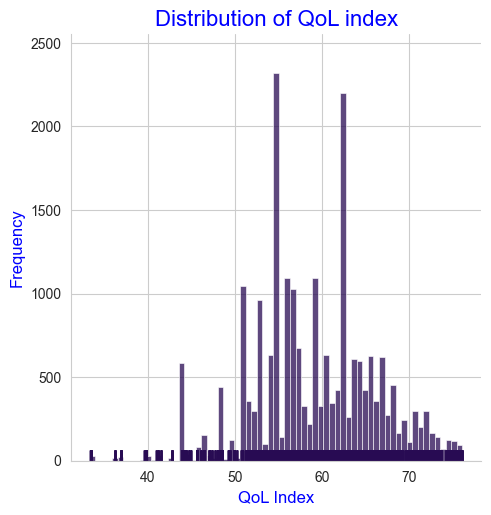

In [6]:
plt.figure(figsize=(10, 6))
seaborn.set_style('whitegrid')
seaborn.set_palette('inferno')
seaborn.displot(eg_labels['qol_index'], rug=True, kde_kws={'fill':True, 'color':'r'})
plt.xlabel('QoL Index', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of QoL index', fontsize=16, color='b')
plt.show()

In [7]:
from keras.src.preprocessing.image import ImageDataGenerator

# create datagenerator object for training and validation datasets
#rescale images using 1/255
eg_train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
eg_train_datagen_flow = eg_train_datagen.flow_from_dataframe(
    dataframe = eg_labels,
    directory='../outputs/tiles',
    x_col="tile", 
    y_col="qol_index",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(256,256),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=42,
    )

Found 22150 validated image filenames.


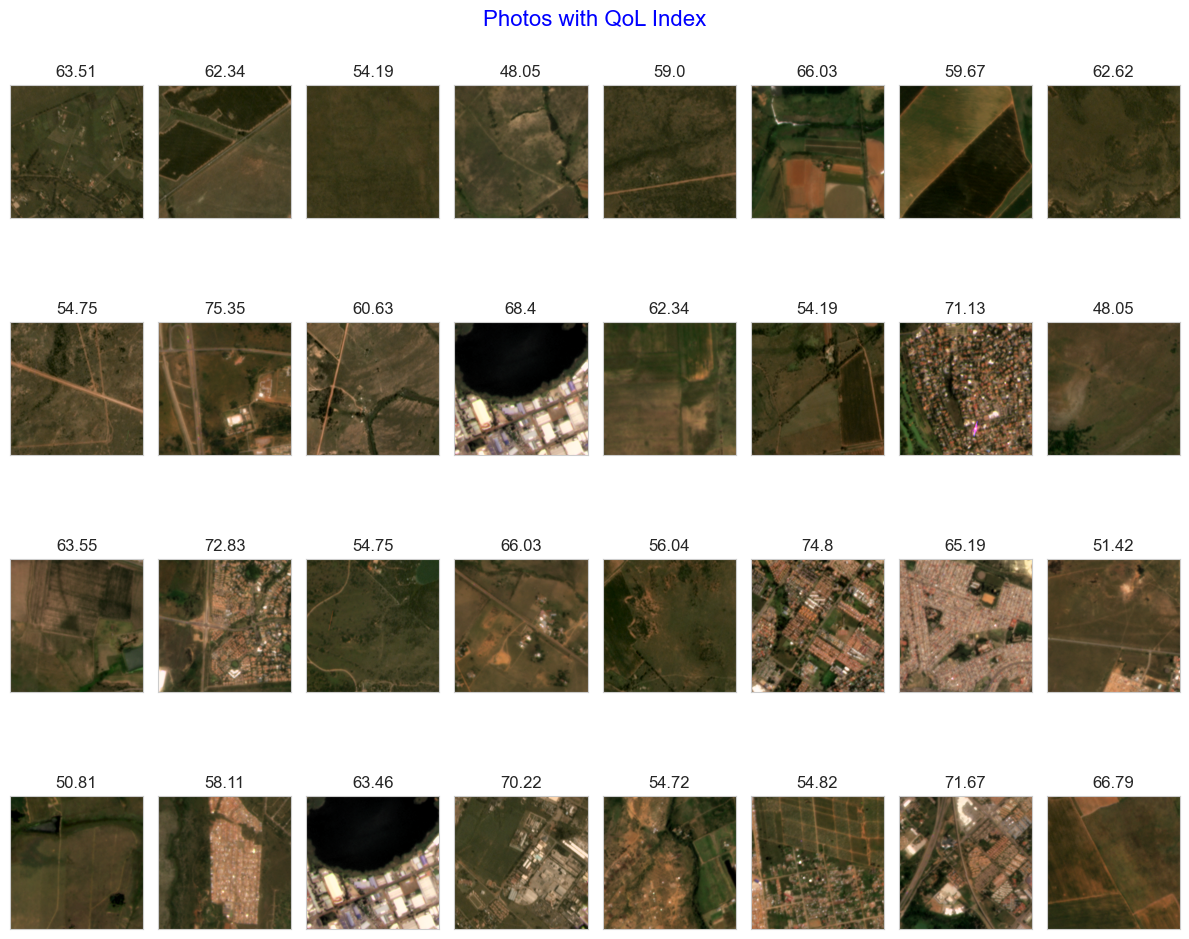

In [8]:
#get one batch from our datagenerator and display images in it
features, target = next(eg_train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{round(target[i], 2)}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with QoL Index',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

## More concrete functions

In [9]:
# TODO: Train, validation AND TEST
def load_dataset(subset):
    
    """
    Loads the subset (training/validation) of the data from path
    """
    
    labels = gpd.read_file('../outputs/matched/gauteng-qol-cluster-tiles.geojson')
    labels = labels[["tile", "qol_index"]]
    data = ImageDataGenerator(validation_split=0.2, rescale=1 / 255)
    data_flow = data.flow_from_dataframe(
        dataframe=labels,
        directory="../outputs/tiles",
        x_col='tile',
        y_col='qol_index',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset = subset,
        seed=42)

    return data_flow

In [10]:

from keras.src.layers import Dropout, GlobalAveragePooling2D, Dense

def create_model(input_shape):
    
    """
    Defines the model
    """
    # Using ResNet50 architecture - freezing base model
    base_model = ResNet50V2(input_shape=input_shape, weights='imagenet', include_top=False)
    base_model.trainable = False

    # Create new model on top
    # Specify input shape
    inputs = Input(shape=(256, 256, 3))
    
    # New model is base model with training set to false
    x = base_model(inputs, training=False)
    # Add averaging layer to ensure fixed size vector
    x = GlobalAveragePooling2D()(x)
    # Add dropout layer to reduce overfitting
    x = Dropout(0.2)(x)
        
    #final layer, since we are doing regression we will add only one neuron (unit)
    outputs = Dense(1, activation='relu')(x)
    added_model = Model(inputs, outputs)

    print(added_model.summary())

    return base_model, added_model

In [11]:
#load training and testing (actually this is validation data set)
train = load_dataset("training")
validation = load_dataset("validation")

Found 17720 validated image filenames.
Found 4430 validated image filenames.


In [12]:
base_model, model = create_model(input_shape = (256, 256, 3))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23564800 (89.89 MB)
__________________

In [15]:
model.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
)

epochs = 2
print("Fitting the top layer of the model")
history_a = model.fit(train, epochs=epochs, validation_data=validation)

Fitting the top layer of the model
Epoch 1/2
554/554 [==============================] - 846s 1s/step - loss: 7568.7871 - val_loss: 746.4217
Epoch 2/2
554/554 [==============================] - 794s 1s/step - loss: 223.6577 - val_loss: 150.6759


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss=MeanSquaredError(),
)

epochs = 10
print("Fitting the end-to-end model")
history_b = model.fit(train, epochs=epochs, validation_data=validation)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 resnet50v2 (Functional)     (None, 8, 8, 2048)        2356480   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                                            
 dense (Dense)               (None, 1)                 2049  